## PHYS2600 Project 
### Band structure models of twisted bilayer graphene 
Based on Bistritzer and MacDonald, PNAS 2011 \
Erin Morissette \
8 April 2021

In [9]:
import numpy as np 
import matplotlib.pyplot as plt
from numba import jit 
import matplotlib

In [426]:
%matplotlib inline

In [432]:
# Setup, parameters for graphene
N = 5 # for 0.5 deg, need N = 5
a = 1.420 # Angstrom, 
w = 110.7 # meV 
vk = 1.5*a*2970 # meV/A
theta = 0.5

# Twist angle
theta = theta*(np.pi/180)
img = complex(0,1)

# For hopping matrices where phi = +/- 2pi/3 
eplus = np.cos(2*np.pi/3) - img*np.sin(2*np.pi/3)
emin = np.cos(2*np.pi/3) + img*np.sin(2*np.pi/3)

# Two Dirac points 
k1 = ((8*np.pi*np.sin(theta/2))/(3*np.sqrt(3)*a)) * np.array([-np.sqrt(3)/2, -1/2])
k2 = ((8*np.pi*np.sin(theta/2))/(3*np.sqrt(3)*a)) * np.array([-np.sqrt(3)/2, 1/2])

qb  = ((8*np.pi*np.sin(theta/2))/(3*np.sqrt(3)*a)) * np.array([0,-1])
qtl = ((8*np.pi*np.sin(theta/2))/(3*a)) * np.array([1/2, np.sqrt(3)/2])
qtr = ((8*np.pi*np.sin(theta/2))/(3*a)) * np.array([1/2, -np.sqrt(3)/2])

In [433]:
# Hopping matrices 
T1 = w * np.array([[1,1], [1,1]], dtype = complex)
T2 = w * np.array([[emin, 1], [eplus, emin]], dtype = complex)
T3 = w * np.array([[eplus, 1], [emin, eplus]], dtype = complex)

# Conjugate transpose hopping matrices 
T1dag = np.array(np.matrix(T1).H)
T2dag = np.array(np.matrix(T2).H)
T3dag = np.array(np.matrix(T3).H)
# print(T1, T2, T3)

C:\Users\Erin Morissette\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  import sys
C:\Users\Erin Morissette\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  
C:\Users\Erin Morissette\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  if __name__ =

In [434]:
# Create lattice 
L = []
L_inv = np.zeros([2*N+1, 2*N+1], int)

def Lattice(n):
    k = 0 
    for x in np.arange(-n, n+1):
        for y in np.arange(-n, n+1):
            L.append([x,y])
            L_inv[x+n,y+n] = k
            k += 1

In [435]:
# Establish lattice with truncation range N
Lattice(N)
sites = (2*N+1)*(2*N+1)
L = np.array(L)

In [436]:
# Build tight-binding Hamiltonian 
# For one valley
# @jit(nopython = True)
def Hamiltonian(kx, ky):
    Ham = np.array(np.zeros((4*sites, 4*sites)), dtype = complex) 
    # each site includes a 4x4 matrix 
    
    for i in np.arange(sites): 
        ix = L[i,0]
        iy = L[i,1]
        
        ax = kx + k1[0] + ix*qtr[0] + iy*qtl[0]
        ay = ky + k1[1] + ix*qtr[1] + iy*qtl[1]
        
        # Rotation matrix times (ax,ay)
        qx = np.cos(theta/2)*ax + np.sin(theta/2)*ay
        qy = -np.sin(theta/2)*ax + np.cos(theta/2)*ay
        
        # Diagonal elements, each diagonal is an off-diagonal 2x2 matrix - the Dirac Hamiltonian
        Ham[2*i, 2*i + 1] = vk * (-qx - img*qy)
        Ham[2*i + 1, 2*i] = vk * (-qx + img*qy)
        
        # Off-diagonal elements, hopping matrices
        j = i + sites
#         Ham[2*j:2*j + 2, 2*i:2*i + 2] = T1dag
        Ham[2*j, 2*i]     = T1dag[0, 0]
        Ham[2*j, 2*i+1]   = T1dag[0, 1]
        Ham[2*j+1, 2*i]   = T1dag[1, 0]
        Ham[2*j+1, 2*i+1] = T1dag[1, 1]
        
        # Boundary conditions for T2 and T3    
        if (iy != -N):
            j = L_inv[ix + N, iy + N -1] + sites 
#             Ham[2*j:2*j + 2, 2*i:2*i + 2] = T2dag
            Ham[2*j, 2*i]     = T3dag[0, 0]
            Ham[2*j, 2*i+1]   = T3dag[0, 1]
            Ham[2*j+1, 2*i]   = T3dag[1, 0]
            Ham[2*j+1, 2*i+1] = T3dag[1, 1]
            
        if (ix != N):
            j = L_inv[ix + N + 1, iy + N] + sites
#             Ham[2*j:2*j + 2, 2*i:2*i + 2] = T3dag
            Ham[2*j, 2*i]     = T2dag[0, 0]
            Ham[2*j, 2*i+1]   = T2dag[0, 1]
            Ham[2*j+1, 2*i]   = T2dag[1, 0]
            Ham[2*j+1, 2*i+1] = T2dag[1, 1]
            
            
    for i in np.arange(sites, 2*sites): # everything the same except K1 to K2 and sign changes
        j = i - sites
        ix = L[j,0]
        iy = L[j,1]
        
        ax = kx + k2[0] + ix*qtr[0] + iy*qtl[0]
        ay = ky + k2[1] + ix*qtr[1] + iy*qtl[1]
        
        # Rotation matrix times (ax,ay)
        qx = np.cos(theta/2)*ax - np.sin(theta/2)*ay
        qy = np.sin(theta/2)*ax + np.cos(theta/2)*ay
        
        Ham[2*i, 2*i + 1] = vk * (-qx - img*qy)
        Ham[2*i + 1, 2*i] = vk * (-qx + img*qy)
        
#         Ham[2*j:2*j + 2, 2*i:2*i + 2] = T1
        Ham[2*j, 2*i]     = T1[0, 0]
        Ham[2*j, 2*i+1]   = T1[0, 1]
        Ham[2*j+1, 2*i]   = T1[1, 0]
        Ham[2*j+1, 2*i+1] = T1[1, 1]
           
        if (iy != (N)):
            j = L_inv[ix + N, iy + N + 1] 
#             Ham[2*j:2*j + 2, 2*i:2*i + 2] = T2
            Ham[2*j, 2*i]     = T3[0, 0]
            Ham[2*j, 2*i+1]   = T3[0, 1]
            Ham[2*j+1, 2*i]   = T3[1, 0]
            Ham[2*j+1, 2*i+1] = T3[1, 1]
            
        if (ix != (-N)):
            j = L_inv[ix + N - 1, iy + N] 
#             Ham[2*j:2*j + 2, 2*i:2*i + 2] = T3
            Ham[2*j, 2*i]     = T2[0, 0]
            Ham[2*j, 2*i+1]   = T2[0, 1]
            Ham[2*j+1, 2*i]   = T2[1, 0]
            Ham[2*j+1, 2*i+1] = T2[1, 1]
            
            
    eigval, eigvec = np.linalg.eig(Ham)
    eigenvalues = np.sort(eigval)
    
    return eigenvalues 

In [437]:
kres = 100 # resolution of the k ranges 
kD = -qb[1] # Dirac-point momentum 
krange1 = np.arange(-1/2, 1/2, 1/kres) # Gamma-K'
krange2 = np.arange(-1, 0, 1/kres) # K'-K''
krange3 = np.arange(0, np.sqrt(3), 1/kres) # K''-K
krange4 = np.arange(0, 1, 1/kres) # K-Gamma


# Setup energy matrix for all 4 k range segments 
krange = 3*kres + len(krange3) 
E  = np.zeros((krange,4*sites), float)

# compute the eigenvalues for each of the 4 ranges: Gamma-K', K'-K'', K''-K, and K-Gamma
for i in range(0, kres):
    k = krange1[i]
    E[i] = np.real(Hamiltonian((np.sqrt(3)/2)*kD, k*kD))
print('Done range 1.')
               
for i in range(kres, 2*kres):
    k = krange2[i-kres]
    E[i] = np.real(Hamiltonian(0, k*kD))
print('Done range 2.')
               
for i in range(2*kres, 2*kres + len(krange3)):
    k = krange3[i-2*kres]
    E[i] = np.real(Hamiltonian(0.5*k*kD, (-k*np.sqrt(3)/2)*kD))
print('Done range 3.')
               
for i in range(2*kres + len(krange3), krange):
    k = krange4[i-(2*kres + len(krange3))]
    E[i] = np.real(Hamiltonian((-np.sqrt(3)/2)*k*kD, (-1/2)*k*kD))
print('Done range 4.')

Done range 1.
Done range 2.
Done range 3.
Done range 4.


<>:7: DeprecationWarning: invalid escape sequence \c
<>:12: DeprecationWarning: invalid escape sequence \G
<>:12: DeprecationWarning: invalid escape sequence \G
<>:7: DeprecationWarning: invalid escape sequence \c
<>:12: DeprecationWarning: invalid escape sequence \G
<>:12: DeprecationWarning: invalid escape sequence \G
<>:7: DeprecationWarning: invalid escape sequence \c
<>:12: DeprecationWarning: invalid escape sequence \G
<>:12: DeprecationWarning: invalid escape sequence \G
<ipython-input-439-bd7c69ba1974>:7: DeprecationWarning: invalid escape sequence \c
  plt.title(r'Moiré bands of tBLG, $\theta$ = ' + str(round(theta*(180/np.pi), 3)) + '$^{\circ}$')
<ipython-input-439-bd7c69ba1974>:12: DeprecationWarning: invalid escape sequence \G
  xlabels = ['$\Gamma$', 'K\'', 'K\'\'', 'K', '$\Gamma$']
<ipython-input-439-bd7c69ba1974>:12: DeprecationWarning: invalid escape sequence \G
  xlabels = ['$\Gamma$', 'K\'', 'K\'\'', 'K', '$\Gamma$']


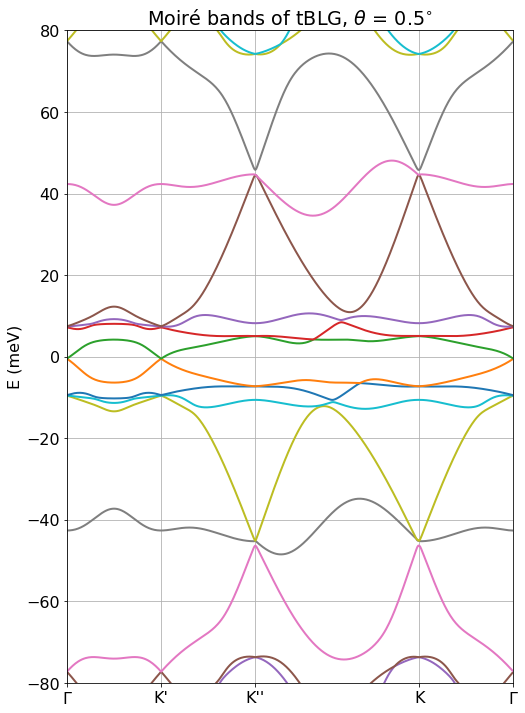

In [439]:
# Plot the bands as a function of the entire k range 
matplotlib.rcParams['figure.figsize'] = (8,12)
matplotlib.rcParams['font.size'] = 16
for j in range(0,4*sites):
    plt.plot(np.arange(krange), E[:,j], linestyle= '-', linewidth=2)

plt.title(r'Moiré bands of tBLG, $\theta$ = ' + str(round(theta*(180/np.pi), 3)) + '$^{\circ}$')
plt.xlim(0, krange)
plt.ylim(-80,80)
plt.ylabel('E (meV)')
# plt.xlabel('k (a.u., $\Gamma$ - K\' - K\'\' - K - $\Gamma$)')
xlabels = ['$\Gamma$', 'K\'', 'K\'\'', 'K', '$\Gamma$']
plt.xticks([0, kres, 2*kres, 2*kres + len(krange3), krange], xlabels)
plt.grid()
plt.show()

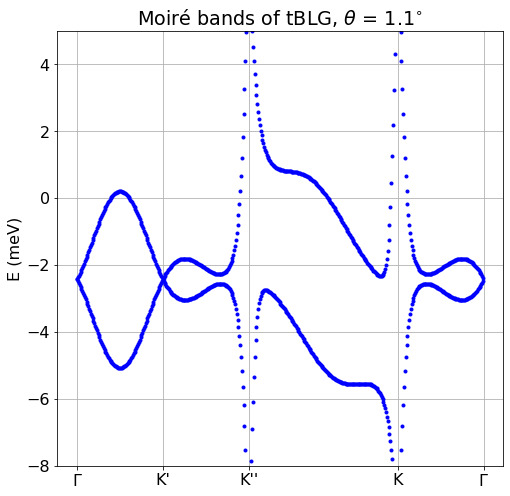

In [131]:
# Plot the bands as a function of the entire k range 
matplotlib.rcParams['figure.figsize'] = (8,8)
matplotlib.rcParams['font.size'] = 16
for j in range(0,4*sites):
    plt.plot(np.arange(krange), E[:,j], linestyle = 'None', marker = '.', color = 'b')

plt.title(r'Moiré bands of tBLG, $\theta$ = ' + str(round(theta*(180/np.pi), 3)) + '$^{\circ}$')
# plt.xlim(0, krange)
xlabels = ['$\Gamma$', 'K\'', 'K\'\'', 'K', '$\Gamma$']
plt.xticks([0, kres, 2*kres, 2*kres + len(krange3), krange], xlabels)
plt.ylim(-8,5)
plt.ylabel('E (meV)')
# plt.xlabel('k (a.u., $\Gamma$ - K\' - K\'\' - K - $\Gamma$)')
# labels = []
# plt.xticks(labels = ['$\Gamma$', 'K', 'K', 'K', '$\Gamma$'])
plt.grid()
plt.show()

In [14]:
print(np.shape(E))
print(np.shape(np.matrix.flatten(E)))

(474, 196)
(92904,)


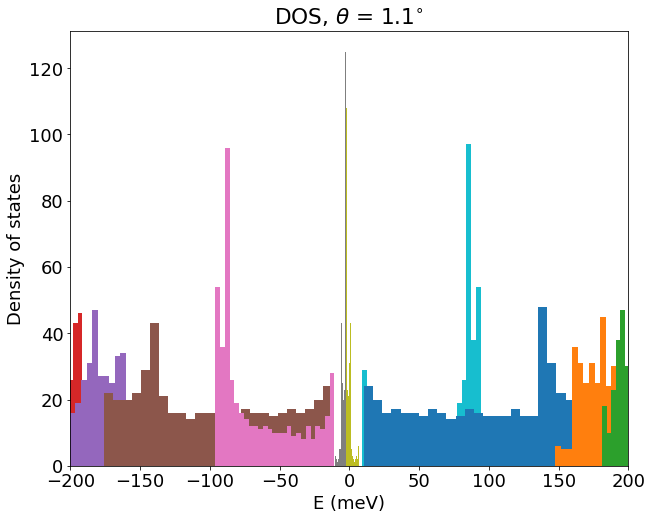

In [132]:
# Density of states histogram
matplotlib.rcParams['figure.figsize'] = (10,8)
for i in range(0, 4*sites):
    plt.hist(E[:,i], bins = 25)
plt.xlim(-200,200)
plt.xlabel('E (meV)')
plt.yticks(ticks = None)
plt.ylabel('Density of states')
plt.title(r'DOS, $\theta$ = ' + str(round(theta*(180/np.pi), 3)) + '$^{\circ}$')
plt.show()

<>:10: DeprecationWarning: invalid escape sequence \c
<>:10: DeprecationWarning: invalid escape sequence \c
<>:10: DeprecationWarning: invalid escape sequence \c
<ipython-input-442-4e701969a3af>:10: DeprecationWarning: invalid escape sequence \c
  plt.title(r'DOS, $\theta$ = ' + str(round(theta*(180/np.pi), 3)) + '$^{\circ}$')


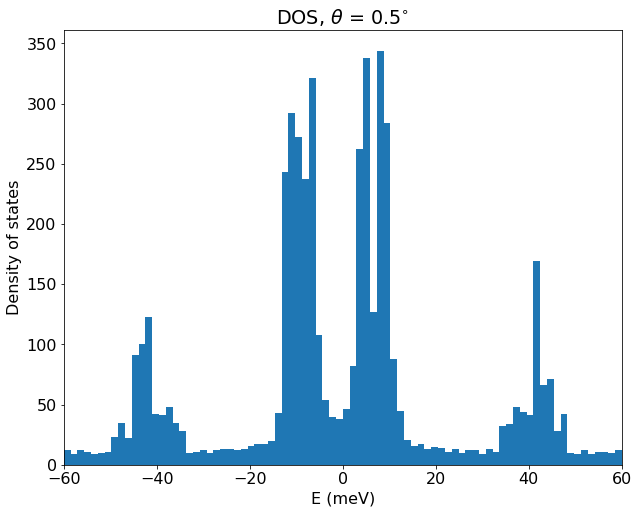

In [442]:
matplotlib.rcParams['figure.figsize'] = (10,8)
# for i in range(0, 4*sites):
#     plt.hist(E[:,i], bins = 25)
plt.hist(np.matrix.flatten(E), bins = 2400)
plt.xlim(-60,60)
# plt.ylim(0,60)
plt.xlabel('E (meV)')
plt.yticks(ticks = None)
plt.ylabel('Density of states')
plt.title(r'DOS, $\theta$ = ' + str(round(theta*(180/np.pi), 3)) + '$^{\circ}$')
plt.show()

## tBLG w/ WSe$_2$
Based on "Proximity-induced SOC and ferromagnetism in magic-angle twisted bilayer graphene" from Jiang-Xiazi Lin, Ya-Hui Zhang*, Erin Morissette, $\textit{et al.}$ (2021) \
*Main theory contributor  

In [526]:
# Setup, parameters for graphene
N = 3 # for 0.5 deg, need N = 5
a = 1.42 # Angstrom, 
tM = 110 # meV 
t = vk # meV/A
theta = 0.98 # angle of tBLG/WSe2 device in the above work

# Parameters to model strain 
alpha = 0.8
beta = 0.02

# SOC parameters 
lambdaI = 3
lambdaR = 0

# Twist angle
theta = theta*(np.pi/180)
img = complex(0,1)

# For hopping matrices where phi = +/- 2pi/3 
eplus = np.cos(2*np.pi/3) - img*np.sin(2*np.pi/3)
emin = np.cos(2*np.pi/3) + img*np.sin(2*np.pi/3)

# Two Dirac points 
k1 = ((8*np.pi*np.sin(theta/2))/(3*np.sqrt(3)*a)) * np.array([-np.sqrt(3)/2, -1/2])
k2 = ((8*np.pi*np.sin(theta/2))/(3*np.sqrt(3)*a)) * np.array([-np.sqrt(3)/2, 1/2])

qb  = ((8*np.pi*np.sin(theta/2))/(3*np.sqrt(3)*a)) * np.array([0,-1])
qtl = ((8*np.pi*np.sin(theta/2))/(3*a)) * np.array([1/2, np.sqrt(3)/2])
qtr = ((8*np.pi*np.sin(theta/2))/(3*a)) * np.array([1/2, -np.sqrt(3)/2])


In [527]:
# Hopping matrices 
T1 = (1-beta)*tM * np.array([[alpha,1], [1,alpha]], dtype = complex)
T2 = tM * np.array([[alpha*emin, 1], [eplus, alpha*emin]], dtype = complex)
T3 = tM * np.array([[alpha*eplus, 1], [emin, alpha*eplus]], dtype = complex)



# Conjugate transpose hopping matrices 
T1dag = np.array(np.matrix(T1).H)
T2dag = np.array(np.matrix(T2).H)
T3dag = np.array(np.matrix(T3).H)
# print(T1, T2, T3)

C:\Users\Erin Morissette\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  if __name__ == '__main__':
C:\Users\Erin Morissette\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Erin Morissette\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.h

In [538]:
# SOC matrices 

tau = -1
s = 1/2
sigma = 1 
Ising = lambdaI * np.array([[tau*s, 0], [0,tau*s]], dtype = complex)

Rashba = lambdaR * (np.array([[img*s*tau*sigma, 0], [0, img*s*tau*sigma]], dtype = complex)
                   - np.array([[-img*sigma*s, 0], [0, img*sigma*s]], dtype = complex))

In [539]:
# Create lattice 
L = []
L_inv = np.zeros([2*N+1, 2*N+1], int)

def Lattice(n):
    k = 0 
    for x in np.arange(-n, n+1):
        for y in np.arange(-n, n+1):
            L.append([x,y])
            L_inv[x+n,y+n] = k
            k += 1

In [540]:
# Establish lattice with truncation range N
Lattice(N)
sites = (2*N+1)*(2*N+1)
L = np.array(L)
# print(L)

In [541]:
# Build tight-binding Hamiltonian 
# For one valley
# @jit(nopython = True)
def Hamiltonian_SOC(kx, ky):
    Ham = np.array(np.zeros((4*sites, 4*sites)), dtype = complex) # each site includes a 4x4 matrix 
    
    for i in np.arange(sites): 
        ix = L[i,0]
        iy = L[i,1]
        
        ax = kx + k1[0] + ix*qtr[0] + iy*qtl[0]
        ay = ky + k1[1] + ix*qtr[1] + iy*qtl[1]
        
        # Rotation matrix times (ax,ay)
        qx = np.cos(theta/2)*ax + np.sin(theta/2)*ay
        qy = -np.sin(theta/2)*ax + np.cos(theta/2)*ay
        
        # Diagonal elements, each diagonal is an off-diagonal 2x2 matrix - the Dirac Hamiltonian
        Ham[2*i, 2*i] = Ising[0,0] + Rashba[0,0]
        Ham[2*i + 1, 2*i + 1] = Ising[1,1] + Rashba[1,1]
        
        Ham[2*i, 2*i + 1] = t * (-qx - img*qy)
        Ham[2*i + 1, 2*i] = t * (-qx + img*qy)
        
        # Off-diagonal elements, hopping matrices
        j = i + sites
#         Ham[2*j:2*j + 2, 2*i:2*i + 2] = T1dag
        Ham[2*j, 2*i]     = T1dag[0, 0]
        Ham[2*j, 2*i+1]   = T1dag[0, 1]
        Ham[2*j+1, 2*i]   = T1dag[1, 0]
        Ham[2*j+1, 2*i+1] = T1dag[1, 1]
        
        # Boundary conditions for T2 and T3    
        if (iy != -N):
            j = L_inv[ix + N, iy + N -1] + sites 
#             Ham[2*j:2*j + 2, 2*i:2*i + 2] = T2dag
            Ham[2*j, 2*i]     = T3dag[0, 0]
            Ham[2*j, 2*i+1]   = T3dag[0, 1]
            Ham[2*j+1, 2*i]   = T3dag[1, 0]
            Ham[2*j+1, 2*i+1] = T3dag[1, 1]
            
        if (ix != N):
            j = L_inv[ix + N + 1, iy + N] + sites
#             Ham[2*j:2*j + 2, 2*i:2*i + 2] = T3dag
            Ham[2*j, 2*i]     = T2dag[0, 0]
            Ham[2*j, 2*i+1]   = T2dag[0, 1]
            Ham[2*j+1, 2*i]   = T2dag[1, 0]
            Ham[2*j+1, 2*i+1] = T2dag[1, 1]
            
            
    for i in np.arange(sites, 2*sites): # everything the same except K1 to K2 and sign changes
        j = i - sites
        ix = L[j,0]
        iy = L[j,1]
        
        ax = kx + k2[0] + ix*qtr[0] + iy*qtl[0]
        ay = ky + k2[1] + ix*qtr[1] + iy*qtl[1]
        
        # Rotation matrix times (ax,ay)
        qx = np.cos(theta/2)*ax - np.sin(theta/2)*ay
        qy = np.sin(theta/2)*ax + np.cos(theta/2)*ay
        
        Ham[2*i, 2*i + 1] = t * (-qx - img*qy)
        Ham[2*i + 1, 2*i] = t * (-qx + img*qy)
        
#         Ham[2*j:2*j + 2, 2*i:2*i + 2] = T1
        Ham[2*j, 2*i]     = T1[0, 0]
        Ham[2*j, 2*i+1]   = T1[0, 1]
        Ham[2*j+1, 2*i]   = T1[1, 0]
        Ham[2*j+1, 2*i+1] = T1[1, 1]
           
        if (iy != (N)):
            j = L_inv[ix + N, iy + N + 1] 
#             Ham[2*j:2*j + 2, 2*i:2*i + 2] = T2
            Ham[2*j, 2*i]     = T3[0, 0]
            Ham[2*j, 2*i+1]   = T3[0, 1]
            Ham[2*j+1, 2*i]   = T3[1, 0]
            Ham[2*j+1, 2*i+1] = T3[1, 1]
            
        if (ix != (-N)):
            j = L_inv[ix + N - 1, iy + N] 
#             Ham[2*j:2*j + 2, 2*i:2*i + 2] = T3
            Ham[2*j, 2*i]     = T2[0, 0]
            Ham[2*j, 2*i+1]   = T2[0, 1]
            Ham[2*j+1, 2*i]   = T2[1, 0]
            Ham[2*j+1, 2*i+1] = T2[1, 1]
            
            
    eigval, eigvec = np.linalg.eig(Ham)
    eigenvalues = np.sort(eigval)
    
    return eigenvalues 

In [542]:
%%time 
kres = 100 # resolution of the k ranges 
kD = -qb[1] # Dirac-point momentum 
krange1 = np.arange(-1/2, 1/2, 1/kres) # Gamma-K'
krange2 = np.arange(-1, 0, 1/kres) # K'-K''
krange3 = np.arange(0, np.sqrt(3), 1/kres) # K''-K
krange4 = np.arange(0, 1, 1/kres) # K-Gamma


# Setup energy matrix for all 4 k range segments 
krange = 3*kres + len(krange3) 
E  = np.zeros((krange,4*sites), float)

# compute the eigenvalues for each of the 4 ranges: Gamma-K', K'-K'', K''-K, and K-Gamma
for i in range(0, kres):
    k = krange1[i]
    E[i] = np.real(Hamiltonian_SOC((np.sqrt(3)/2)*kD, k*kD))
print('Done range 1.')
               
for i in range(kres, 2*kres):
    k = krange2[i-kres]
    E[i] = np.real(Hamiltonian_SOC(0, k*kD))
print('Done range 2.')
               
for i in range(2*kres, 2*kres + len(krange3)):
    k = krange3[i-2*kres]
    E[i] = np.real(Hamiltonian_SOC(0.5*k*kD, (-k*np.sqrt(3)/2)*kD))
print('Done range 3.')
               
for i in range(2*kres + len(krange3), krange):
    k = krange4[i-(2*kres + len(krange3))]
    E[i] = np.real(Hamiltonian_SOC((-np.sqrt(3)/2)*k*kD, (-1/2)*k*kD))
print('Done range 4.')

Done range 1.
Done range 2.
Done range 3.
Done range 4.
Wall time: 30 s


<>:7: DeprecationWarning: invalid escape sequence \c
<>:7: DeprecationWarning: invalid escape sequence \l
<>:8: DeprecationWarning: invalid escape sequence \l
<>:12: DeprecationWarning: invalid escape sequence \G
<>:12: DeprecationWarning: invalid escape sequence \G
<>:7: DeprecationWarning: invalid escape sequence \c
<>:7: DeprecationWarning: invalid escape sequence \l
<>:8: DeprecationWarning: invalid escape sequence \l
<>:12: DeprecationWarning: invalid escape sequence \G
<>:12: DeprecationWarning: invalid escape sequence \G
<>:7: DeprecationWarning: invalid escape sequence \c
<>:7: DeprecationWarning: invalid escape sequence \l
<>:8: DeprecationWarning: invalid escape sequence \l
<>:12: DeprecationWarning: invalid escape sequence \G
<>:12: DeprecationWarning: invalid escape sequence \G
<ipython-input-511-c169eae679cc>:7: DeprecationWarning: invalid escape sequence \c
  plt.title(r'$\theta$ = ' + str(round(theta*(180/np.pi), 3)) + '$^{\circ}$,' + ' $\lambda_I$ = ' + str(lambdaI)
<ip

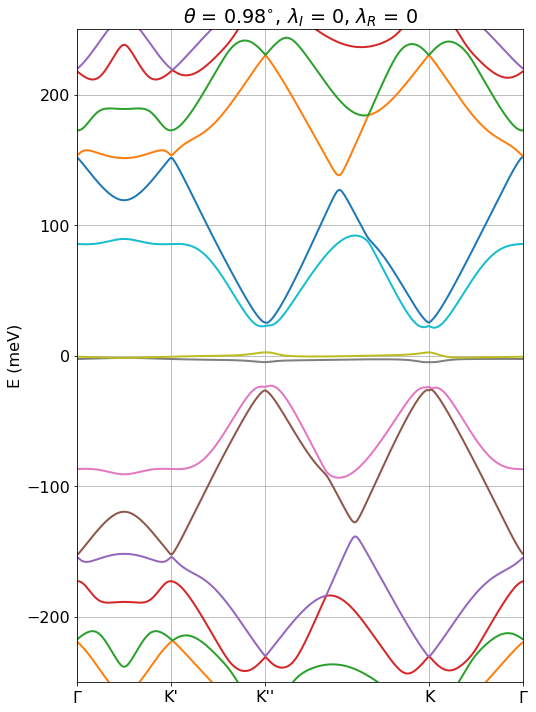

In [511]:
# Plot the bands as a function of the entire k range 
matplotlib.rcParams['figure.figsize'] = (8,12)
matplotlib.rcParams['font.size'] = 16
for j in range(0,4*sites):
    plt.plot(np.arange(krange), E[:,j], linestyle= '-', linewidth=2)

plt.title(r'$\theta$ = ' + str(round(theta*(180/np.pi), 3)) + '$^{\circ}$,' + ' $\lambda_I$ = ' + str(lambdaI)
         + ', $\lambda_R$ = ' + str(lambdaR))
plt.xlim(0, krange)
plt.ylim(-250,250)
plt.ylabel('E (meV)')
xlabels = ['$\Gamma$', 'K\'', 'K\'\'', 'K', '$\Gamma$']
plt.xticks([0, kres, 2*kres, 2*kres + len(krange3), krange], xlabels)
plt.grid()
plt.show()

<>:10: DeprecationWarning: invalid escape sequence \c
<>:10: DeprecationWarning: invalid escape sequence \c
<>:10: DeprecationWarning: invalid escape sequence \c
<ipython-input-514-0dce33f693b4>:10: DeprecationWarning: invalid escape sequence \c
  plt.title(r'DOS, $\theta$ = ' + str(round(theta*(180/np.pi), 3)) + '$^{\circ}$')


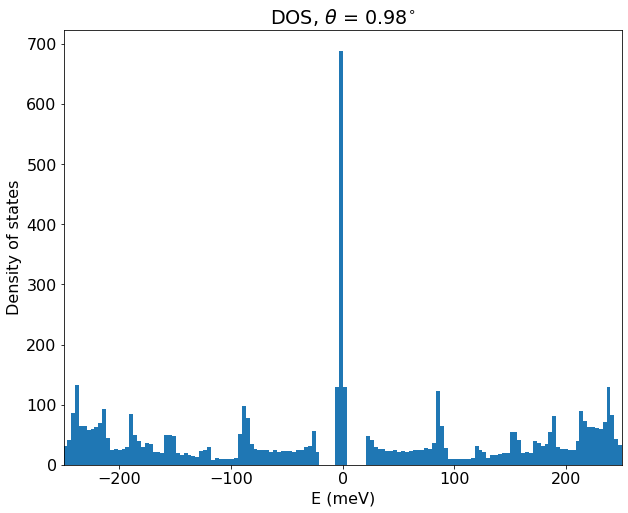

In [514]:
matplotlib.rcParams['figure.figsize'] = (10,8)
# for i in range(0, 4*sites):
#     plt.hist(E[:,i], bins = 25)
plt.hist(np.matrix.flatten(E), bins = 1200)
plt.xlim(-250,250)
# plt.ylim(0,60)
plt.xlabel('E (meV)')
plt.yticks(ticks = None)
plt.ylabel('Density of states')
plt.title(r'DOS, $\theta$ = ' + str(round(theta*(180/np.pi), 3)) + '$^{\circ}$')
plt.show()

<>:8: DeprecationWarning: invalid escape sequence \c
<>:8: DeprecationWarning: invalid escape sequence \l
<>:9: DeprecationWarning: invalid escape sequence \l
<>:11: DeprecationWarning: invalid escape sequence \G
<>:11: DeprecationWarning: invalid escape sequence \G
<>:8: DeprecationWarning: invalid escape sequence \c
<>:8: DeprecationWarning: invalid escape sequence \l
<>:9: DeprecationWarning: invalid escape sequence \l
<>:11: DeprecationWarning: invalid escape sequence \G
<>:11: DeprecationWarning: invalid escape sequence \G
<>:8: DeprecationWarning: invalid escape sequence \c
<>:8: DeprecationWarning: invalid escape sequence \l
<>:9: DeprecationWarning: invalid escape sequence \l
<>:11: DeprecationWarning: invalid escape sequence \G
<>:11: DeprecationWarning: invalid escape sequence \G
<ipython-input-544-914be0930928>:8: DeprecationWarning: invalid escape sequence \c
  plt.title(r'$\theta$ = ' + str(round(theta*(180/np.pi), 3)) + '$^{\circ}$,' + ' $\lambda_I$ = ' + str(lambdaI)
<ip

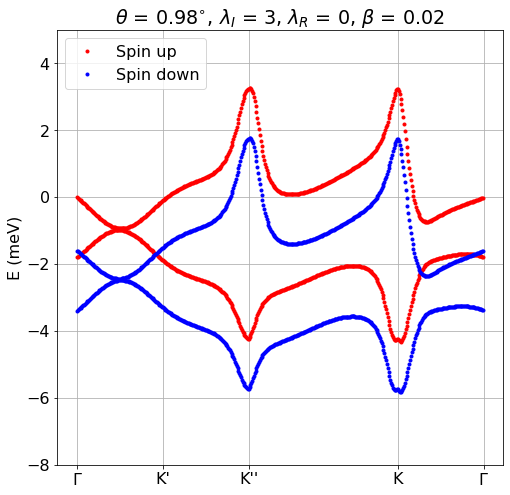

In [544]:
# Plot the bands as a function of the entire k range 
matplotlib.rcParams['figure.figsize'] = (8,8)
matplotlib.rcParams['font.size'] = 16
for j in range(0,4*sites):
    plt.plot(np.arange(krange), E[:,j], linestyle = 'None', marker = '.', color = 'r')
    plt.plot(np.arange(krange), E2[:,j], linestyle = 'None', marker = '.', color = 'b')

plt.title(r'$\theta$ = ' + str(round(theta*(180/np.pi), 3)) + '$^{\circ}$,' + ' $\lambda_I$ = ' + str(lambdaI)
         + ', $\lambda_R$ = ' + str(lambdaR) + r', $\beta$ = 0.02')
# plt.xlim(0, krange)
xlabels = ['$\Gamma$', 'K\'', 'K\'\'', 'K', '$\Gamma$']
plt.xticks([0, kres, 2*kres, 2*kres + len(krange3), krange], xlabels)
plt.ylim(-8,5)
plt.ylabel('E (meV)')
# plt.xlabel('k (a.u., $\Gamma$ - K\' - K\'\' - K - $\Gamma$)')
# labels = []
# plt.xticks(labels = ['$\Gamma$', 'K', 'K', 'K', '$\Gamma$'])
plt.legend(['Spin up', 'Spin down'])
plt.grid()
plt.show()

### Kwant testing
Examples from Kwant documentation, see other .py files for AB-BLG and tBLG

In [204]:
import kwant 

C:\Users\Erin Morissette\Anaconda3\lib\site-packages\kwant\solvers\default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


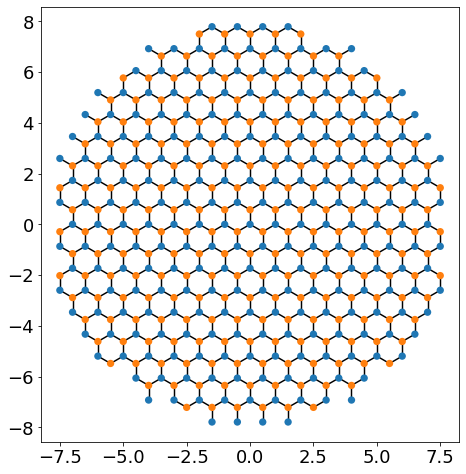

In [134]:
# Define honeycomb "lattice" for graphene 
def rect(pos):
    x, y = pos
    return x**2 + y**2 < 8**2

lat = kwant.lattice.honeycomb()
syst = kwant.Builder()
syst[lat.shape(disk, (0, 0))] = 0
syst[lat.neighbors()] = -1

kwant.plot(syst);


C:\Users\Erin Morissette\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: The plotted data contains 1.54% of values overflowing upper limit 0.0389414 
  # Remove the CWD from sys.path while we load stuff.


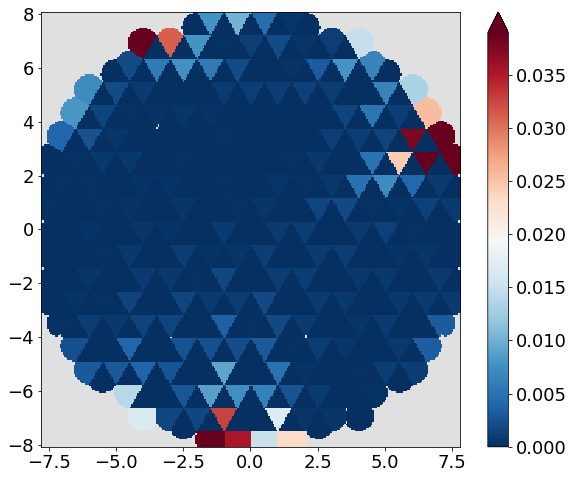

In [136]:
def plot_data(syst, n):
    import scipy.linalg as la

    syst = syst.finalized()
    ham = syst.hamiltonian_submatrix()
    evecs = la.eigh(ham)[1]

    wf = abs(evecs[:, n])**2
    
    kwant.plotter.map(syst, wf, oversampling=10, cmap='RdBu_r')
    
plot_data(syst,225)
    
# def site_size(i):
#         return 3 * wf[i] / wf.max()

# kwant.plot(syst, site_size=site_size, site_color=(0, 0, 1, 0.3),
#                hop_lw=0.1)

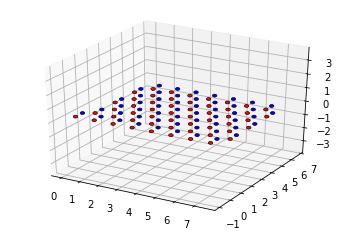

In [366]:
# lat = kwant.lattice.general([(0, 0.5, 0.5), (0.5, 0, 0.5), (0.5, 0.5, 0)],
#                             [(0, 0, 0), (0.25, 0.25, 0.25)])
# a, b = lat.sublattices
%matplotlib inline
graphene = kwant.lattice.general([(1, 0, 0), (np.sin(np.pi/6), np.cos(np.pi/6), 0)],
                                 [(0, 0, 0), (0, 1 / np.sqrt(3), 0), 
                                   (0, 0, -1/2), (0, 1/np.sqrt(3), -1/2)])
# graphene2 = kwant.lattice.general([(1, 0, 0), (np.sin(np.pi/6), np.cos(np.pi/6), 0)],
#                                  [(0, 0, 0), (0, 1 / np.sqrt(3), 0)])
#                                 [(1, 0, -1/2), (np.sin(np.pi/6), np.cos(np.pi/6), -1/2)],
#                                  [(0, 0, -1/2), (0, 1 / np.sqrt(3), -1/2)])
a, b, c, d = graphene.sublattices

def make_stack(a = 8, b = 6, c = 5, t = -1, tp = 0.1):
    def rect_shape(pos):
        x, y, z = pos
        return 0 <= x < a and 0 <= y < b and 0 <= z < c
    
#     lat = kwant.lattice.honeycomb()
    syst = kwant.Builder()
    syst[graphene.shape(rect_shape, (0, 0, 0))] = None
#     syst[graphene.shape(rect_shape, (0, 0, 0))] = 0
    sys[graphene.neighbors()] = t
    sys.eradicate_dangling()
    if tp:
        sys[graphene.neighbors(2)] = tp
    
    return syst

sys = make_stack()

# kwant.plot(sys)
def family_colors(site):
    if site.family == a:
        return 'r'
    if site.family == b:
        return 'b'
    if site.family == c:
        return 'g' 
    if site.family == d:
        return 'c'

kwant.plot(sys, site_size=0.3, site_lw=0.1, hop_lw=10, site_color=family_colors);

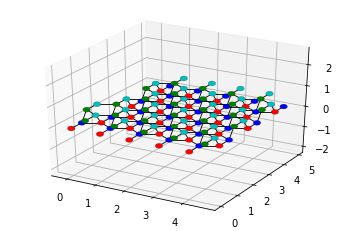

In [382]:
# lat = kwant.lattice.general([(0, 0.5, 0.5), (0.5, 0, 0.5), (0.5, 0.5, 0)],
#                             [(0, 0, 0), (0.25, 0.25, 0.25)])

%matplotlib qt
lat = kwant.lattice.general([(1,0,0), (np.sin(np.pi/6), np.cos(np.pi/6), 0)], 
                           [(0,0,0), (0, 1/np.sqrt(3), 0), (1/2, 0, 1/2), (1/2, 1/np.sqrt(3), 1/2)])
a, b, c, d = lat.sublattices

def make_cuboid(a=15, b=10, c=5):
    def cuboid_shape(pos):
        x, y, z = pos
        return 0 <= x < a and 0 <= y < b and 0 <= z < c

    sys = kwant.Builder()
    sys[lat.shape(cuboid_shape, (0, 0, 0))] = None
    sys[lat.neighbors()] = None

    return sys

sys = make_cuboid(a=5, b=5, c=5)

def family_colors(site):
    if site.family == a:
        return 'r'
    if site.family == b:
        return 'b'
    if site.family == c:
        return 'g' 
    if site.family == d:
        return 'c'

kwant.plot(sys, site_size=0.18, site_lw=0.01, hop_lw=0.05,
            site_color=family_colors);